<a href="https://colab.research.google.com/github/Muntasir2179/bangla-accent-classification/blob/model-testing/Accent_Classification_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries and dataset

In [1]:
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 35.7 MB/s eta 0:00:00


In [2]:
# data visualization libraries
import resampy
import librosa
import pandas as pd
import os
import seaborn as sns
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# data preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# model building libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, BatchNormalization, Dropout, Flatten, Conv2D, MaxPool2D

In [3]:
audio_dataset_path='/content/drive/MyDrive/Datasets/Bangla Accent Dataset/audio/'
metadata=pd.read_csv('/content/drive/MyDrive/Datasets/Bangla Accent Dataset/audio_trace_metadata.csv')

In [4]:
metadata = metadata.sample(frac=1, random_state=42)
metadata.head()

,file_name,folder_name,accent
781,noakhali_audio_98.wav,noakhali,noakhali
1149,shatkhira_audio_27.wav,shatkhira,shatkhira
673,noakhali_audio_159.wav,noakhali,noakhali
439,kurigram_audio_79.wav,kurigram,kurigram
736,noakhali_audio_53.wav,noakhali,noakhali


In [5]:
len(metadata)

1244

In [6]:
metadata['accent'].value_counts()

noakhali       184
pabna          164
chottogram     147
barishal       114
puran dhaka    104
bogura         100
madaripur       90
kurigram        80
rajshahi        72
maymenshing     68
thakurgaon      66
shatkhira       33
sylhet          22
Name: accent, dtype: int64

# Extracting features

In [7]:
# defining a function that can extract features from audio files
import librosa

def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=128)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

    return mfccs_scaled_features

In [8]:
# collecting features for all the audio files
from tqdm import tqdm

extracted_features=[]

for index_num, row in tqdm(metadata.iterrows()):
  accent_label = row['accent']
  file_path = '/content/drive/MyDrive/Datasets/Bangla Accent Dataset/audio/' + str(row['folder_name']) + '/' + str(row['file_name'])
  data = features_extractor(file_path)
  extracted_features.append([data, accent_label])

1244it [17:06,  1.21it/s]


In [9]:
# converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-319.60324, 100.93008, -49.853462, 14.209036,...",noakhali
1,"[-301.0043, 132.1078, -18.331856, 14.114234, -...",shatkhira
2,"[-279.92896, 158.58873, -21.682814, 18.628054,...",noakhali
3,"[-321.4388, 94.2353, -51.97351, -4.6769466, -1...",kurigram
4,"[-357.3672, 140.95932, -6.213394, 10.800049, -...",noakhali


In [12]:
# saving the extracted features dataframe into drive for later use
extracted_features_df.to_csv('/content/drive/MyDrive/Datasets/Bangla Accent Dataset/128_audio_features.csv')

In [13]:
# Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [14]:
X.shape, y.shape

((1244, 128), (1244,))

# Applying onehot encoding on labels

In [15]:
encoder = OneHotEncoder()
y = encoder.fit_transform(y.reshape(-1, 1)).toarray()
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [16]:
y.shape

(1244, 13)

In [17]:
import pickle
with open("/content/drive/MyDrive/Colab Notebooks/Accent Classification/Saved Models/onehot_encoder_accent_classification.pkl", "wb") as f:
    pickle.dump(encoder, f)

# Spliting dataset into train and test

In [18]:
# split the data to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print the details
print("Number of training samples = ", X_train.shape[0])
print("Number of testing samples = ", X_test.shape[0])

Number of training samples =  995
Number of testing samples =  249


# Helper functions for plotting and evaluation

In [19]:
# function for Ploting history (also known as a loss curve or a training curve)
def plot_history(history):
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [20]:
# function to predict and generate decoded value of labels
def model_prediction(x_test, y_true, model, number_of_labels, onehot_encoder):
  y_pred = model.predict(x_test, verbose=0)
  predictions = []
  for row in y_pred:
    label = np.zeros(number_of_labels)
    label[np.argmax(row)] = 1
    label.reshape(1, -1)
    predictions.append(label.tolist())
    label = None
  y_test_decoded = onehot_encoder.inverse_transform(y_true)
  y_pred_decoded = onehot_encoder.inverse_transform(predictions)
  return y_pred_decoded, y_test_decoded

In [21]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def show_evaluation_parameters(X_test, y_test, ANN_Model, number_of_labels, encoder):
  predictions, y_test_for_eval = model_prediction(X_test, y_test, ANN_Model, number_of_labels, encoder)
  print('Accuracy score : ', accuracy_score(y_test_for_eval, predictions))
  print('Precision score: ', precision_score(y_test_for_eval, predictions, average='weighted'))
  print('Recall score   : ', recall_score(y_test_for_eval, predictions, average='weighted'))
  print('F1 Score       : ', f1_score(y_test_for_eval, predictions, average='weighted'))
  print('\n--------------------------------------------\n')
  print(classification_report(y_test_for_eval, predictions))

In [22]:
def show_confusion_matrix(X_test, y_test, ANN_Model, number_of_labels, encoder):
  predictions, y_test_for_eval = model_prediction(X_test, y_test, ANN_Model, number_of_labels, encoder)
  cm = confusion_matrix(y_test_for_eval, predictions, labels=metadata['accent'].unique())
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=metadata['accent'].unique())
  fig, ax = plt.subplots(figsize=(20,13))
  disp.plot(ax=ax)
  plt.show()

# Building ANN model

In [68]:
# Construct model
num_labels = y.shape[1]
ANN_Model = Sequential()
ANN_Model.add(Dense(1000, activation="relu", input_shape=(128,)))
ANN_Model.add(Dropout(0.1))
ANN_Model.add(Dense(750, activation="relu"))
ANN_Model.add(Dropout(0.1))
ANN_Model.add(Dense(500, activation="relu"))
ANN_Model.add(Dropout(0.1))
ANN_Model.add(Dense(250, activation="relu"))
ANN_Model.add(Dropout(0.1))
ANN_Model.add(Dense(100, activation="relu"))
ANN_Model.add(Dropout(0.1))
ANN_Model.add(Dense(50, activation="relu"))
ANN_Model.add(Dropout(0.1))
ANN_Model.add(Dense(30, activation="relu"))
ANN_Model.add(Dense(num_labels, activation="softmax"))

In [69]:
ANN_Model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0008),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

In [70]:
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_accuracy') > 0.91:
      self.model.stop_training = True

callback = MyCallback()

In [71]:
num_epochs = 150
num_batch_size = 5

ANN_Results = ANN_Model.fit(X_train,
                            y_train,
                            batch_size=num_batch_size,
                            epochs=num_epochs,
                            validation_data=(X_test, y_test),
                            # callbacks=[callback]
                            )

Epoch 1/150
199/199 [==============================] - 4s 6ms/step - loss: 2.9296 - accuracy: 0.0965 - val_loss: 2.6025 - val_accuracy: 0.1325
Epoch 2/150
199/199 [==============================] - 1s 7ms/step - loss: 2.5402 - accuracy: 0.1106 - val_loss: 2.5173 - val_accuracy: 0.1566
Epoch 3/150
199/199 [==============================] - 1s 7ms/step - loss: 2.4720 - accuracy: 0.1437 - val_loss: 2.4276 - val_accuracy: 0.1325
Epoch 4/150
199/199 [==============================] - 1s 7ms/step - loss: 2.2867 - accuracy: 0.1990 - val_loss: 2.2205 - val_accuracy: 0.2811
Epoch 5/150
199/199 [==============================] - 1s 5ms/step - loss: 2.0692 - accuracy: 0.2834 - val_loss: 2.0109 - val_accuracy: 0.3655
Epoch 6/150
199/199 [==============================] - 1s 5ms/step - loss: 1.8774 - accuracy: 0.3347 - val_loss: 1.9331 - val_accuracy: 0.3534
Epoch 7/150
199/199 [==============================] - 1s 5ms/step - loss: 1.7291 - accuracy: 0.4201 - val_loss: 1.6034 - val_accuracy: 0.4538

In [72]:
test_accuracy=ANN_Model.evaluate(X_test, y_test, verbose=0)
print(test_accuracy[1])

0.891566276550293


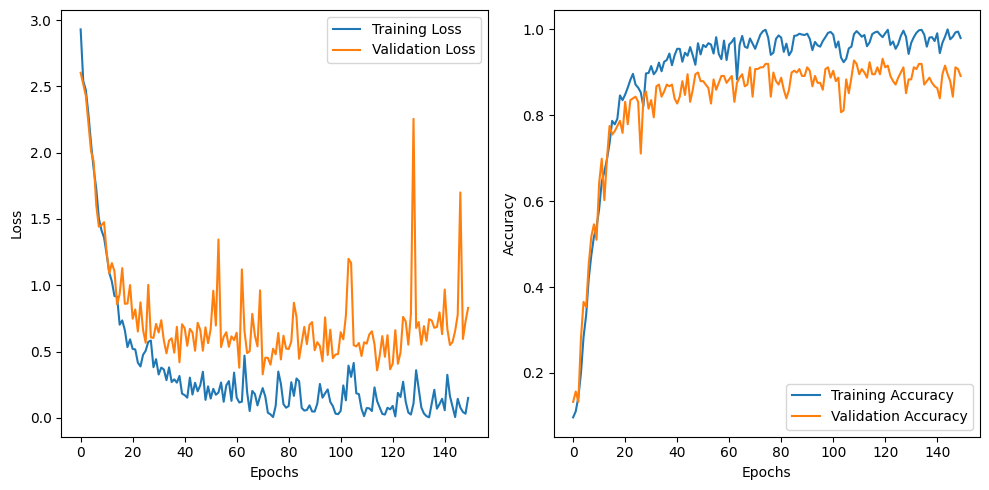

In [73]:
plot_history(ANN_Results)

In [58]:
show_evaluation_parameters(X_test, y_test, ANN_Model, num_labels, encoder)

Accuracy score :  0.8995983935742972
Precision score:  0.9053388335215333
Recall score   :  0.8995983935742972
F1 Score       :  0.9011541863886025

--------------------------------------------

              precision    recall  f1-score   support

    barishal       1.00      0.95      0.97        19
      bogura       0.95      0.86      0.90        21
  chottogram       0.86      0.94      0.90        33
    kurigram       1.00      0.88      0.94        17
   madaripur       1.00      1.00      1.00        13
 maymenshing       1.00      1.00      1.00        16
    noakhali       0.91      0.88      0.90        34
       pabna       0.88      0.91      0.90        33
 puran dhaka       0.95      0.86      0.90        21
    rajshahi       0.74      0.78      0.76        18
   shatkhira       1.00      1.00      1.00         6
      sylhet       0.33      0.40      0.36         5
  thakurgaon       0.87      1.00      0.93        13

    accuracy                           0.90    

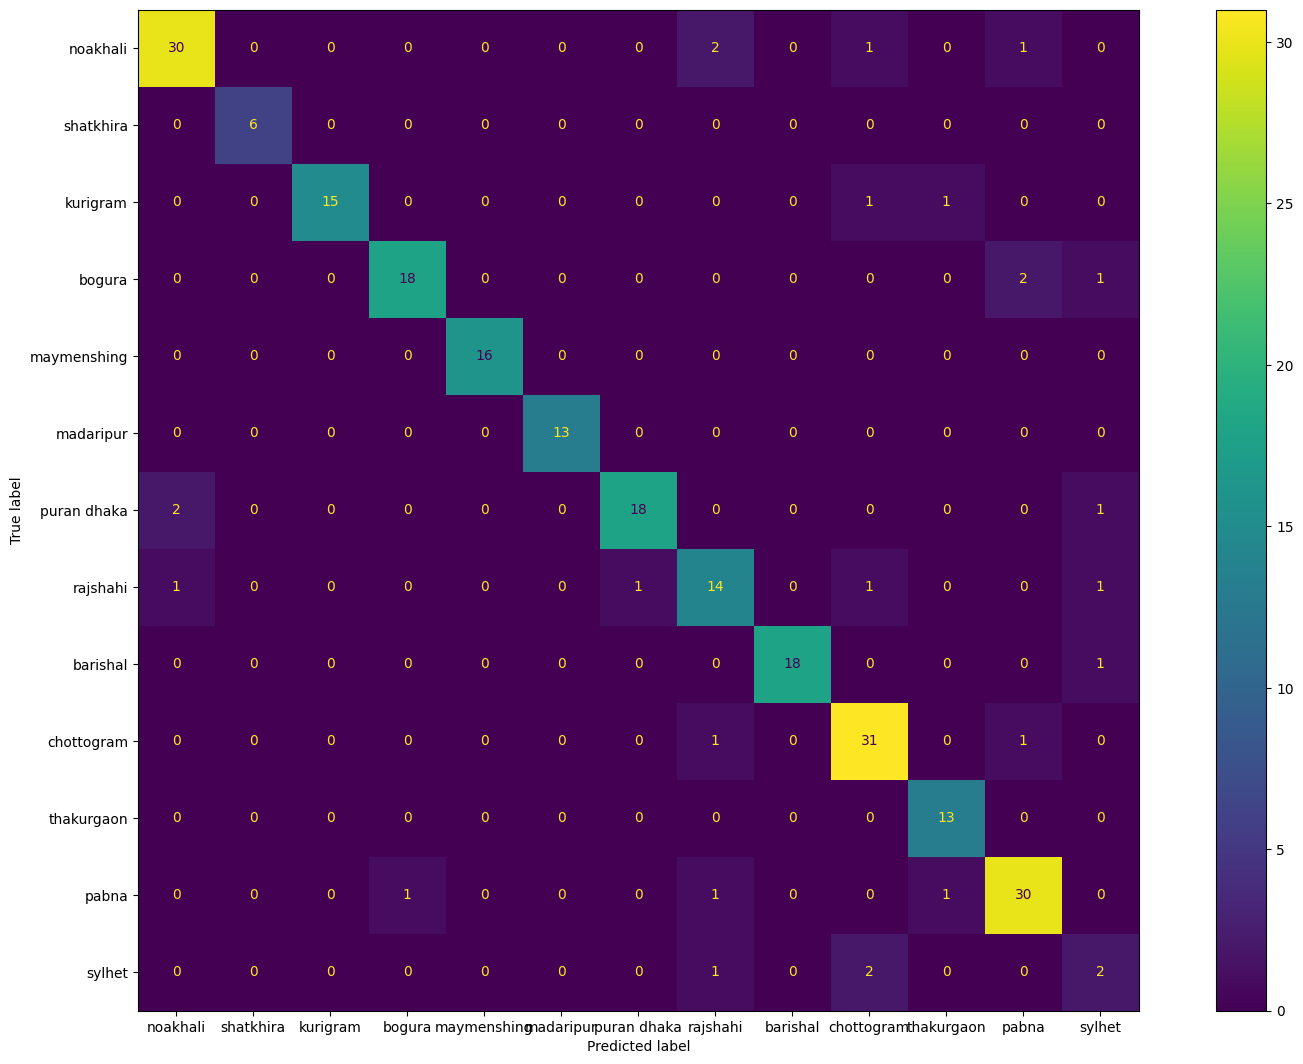

In [59]:
show_confusion_matrix(X_test, y_test, ANN_Model, num_labels, encoder)

In [ ]:
# saving the model
ANN_Model.save('/content/drive/MyDrive/Colab Notebooks/Accent Classification/Saved Models/ANN_Model_val_acc_93%.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# loading the model
loaded_ann_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Accent Classification/Saved Models/ANN_Model_val_acc_93%.h5')

In [ ]:
result = loaded_ann_model.evaluate(X_test, y_test, verbose=0)
print(result[1])

0.9281768202781677


# Building CNN1D model

In [31]:
CNN1D_Model = Sequential()
CNN1D_Model.add(Conv1D(256, 5, strides=1, padding="same", activation="relu", input_shape=(X_train.shape[1], 1),))
CNN1D_Model.add(BatchNormalization())
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(256, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(128, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(64, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Flatten())
CNN1D_Model.add(Dense(units=1024, activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(Dense(units=num_labels, activation="softmax"))

In [32]:
CNN1D_Model.compile(optimizer="adam",
                    loss="categorical_crossentropy",
                    metrics=["accuracy"])

In [33]:
CNN1D_Results = CNN1D_Model.fit(X_train,
                                y_train,
                                batch_size=5,
                                epochs=250,
                                validation_data=(X_test, y_test))

Epoch 1/250
199/199 [==============================] - 9s 8ms/step - loss: 2.7305 - accuracy: 0.1236 - val_loss: 2.4623 - val_accuracy: 0.1446
Epoch 2/250
199/199 [==============================] - 1s 6ms/step - loss: 2.4747 - accuracy: 0.1518 - val_loss: 2.4659 - val_accuracy: 0.1526
Epoch 3/250
199/199 [==============================] - 1s 6ms/step - loss: 2.4160 - accuracy: 0.1940 - val_loss: 2.3472 - val_accuracy: 0.2048
Epoch 4/250
199/199 [==============================] - 1s 6ms/step - loss: 2.3151 - accuracy: 0.2171 - val_loss: 2.1648 - val_accuracy: 0.2691
Epoch 5/250
199/199 [==============================] - 1s 7ms/step - loss: 2.2169 - accuracy: 0.2503 - val_loss: 2.1555 - val_accuracy: 0.2691
Epoch 6/250
199/199 [==============================] - 2s 9ms/step - loss: 2.1203 - accuracy: 0.2774 - val_loss: 2.1931 - val_accuracy: 0.2570
Epoch 7/250
199/199 [==============================] - 2s 8ms/step - loss: 2.0442 - accuracy: 0.3005 - val_loss: 1.9771 - val_accuracy: 0.2851

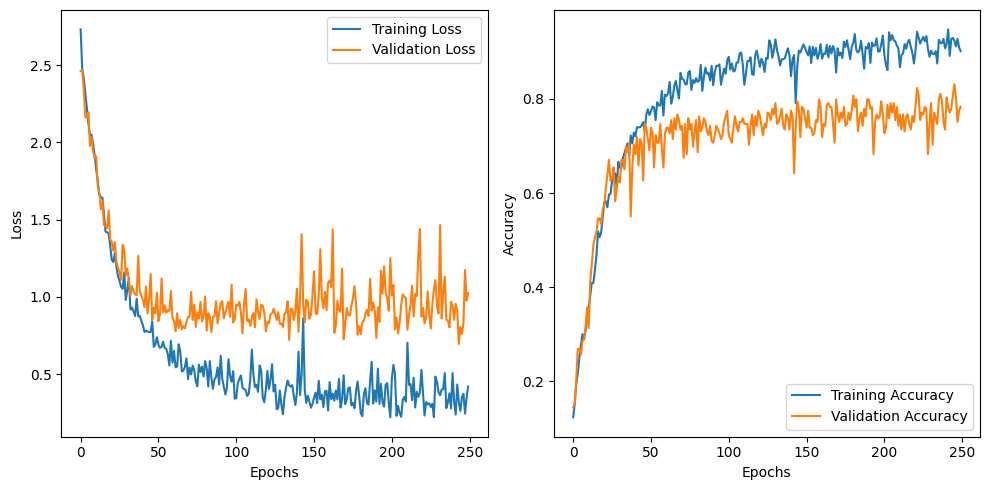

In [34]:
plot_history(CNN1D_Results)

In [35]:
show_evaluation_parameters(X_test, y_test, CNN1D_Model, num_labels, encoder)

Accuracy score :  0.7831325301204819
Precision score:  0.7890634612575006
Recall score   :  0.7831325301204819
F1 Score       :  0.777490380655492

--------------------------------------------

              precision    recall  f1-score   support

    barishal       0.86      1.00      0.93        19
      bogura       0.90      0.86      0.88        21
  chottogram       0.85      0.70      0.77        33
    kurigram       0.89      0.94      0.91        17
   madaripur       0.93      1.00      0.96        13
 maymenshing       1.00      0.94      0.97        16
    noakhali       0.74      0.82      0.78        34
       pabna       0.69      0.76      0.72        33
 puran dhaka       0.78      0.67      0.72        21
    rajshahi       0.56      0.28      0.37        18
   shatkhira       0.43      1.00      0.60         6
      sylhet       0.40      0.40      0.40         5
  thakurgaon       0.85      0.85      0.85        13

    accuracy                           0.78     

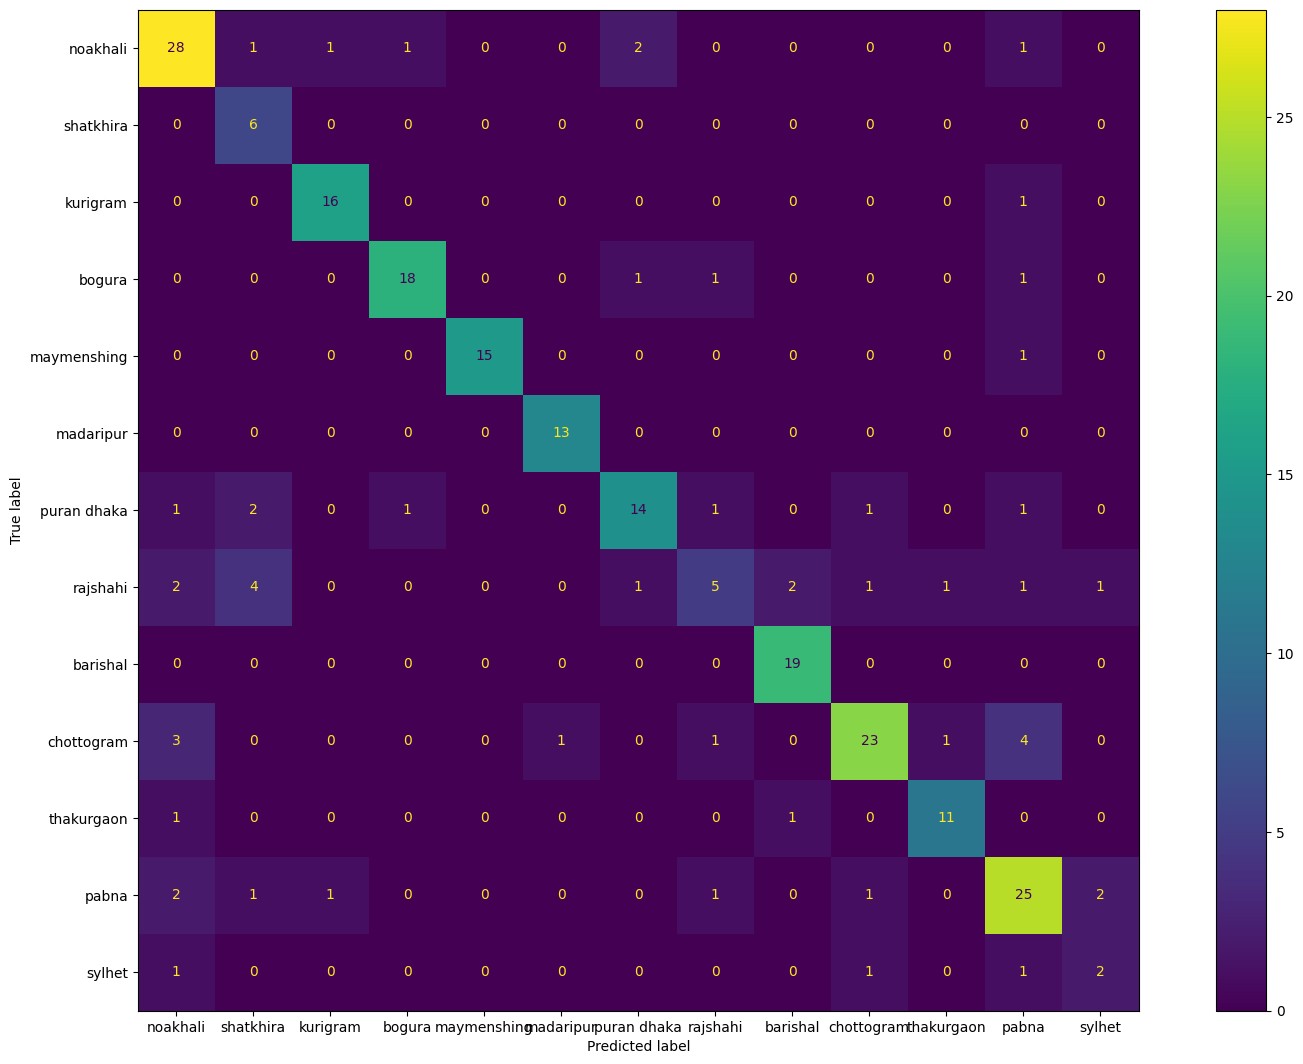

In [36]:
show_confusion_matrix(X_test, y_test, CNN1D_Model, num_labels, encoder)

# Building CNN2D model

In [37]:
# reshaping features to pass into the model
X_train_reshaped = X_train.reshape(X_train.shape[0], 16, 8, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], 16, 8, 1)

In [38]:
CNN2D_Model = Sequential()
CNN2D_Model.add(Conv2D(64, (3, 3), padding="same", activation="tanh", input_shape=(16, 8, 1)))
CNN2D_Model.add(MaxPool2D(pool_size=(2, 2)))
CNN2D_Model.add(Conv2D(128, (3, 3), padding="same", activation="tanh"))
CNN2D_Model.add(MaxPool2D(pool_size=(2, 2)))
CNN2D_Model.add(Dropout(0.1))
CNN2D_Model.add(Flatten())
CNN2D_Model.add(Dense(256, activation="tanh"))
CNN2D_Model.add(Dense(num_labels, activation="softmax"))

In [39]:
CNN2D_Model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
                    loss="categorical_crossentropy",
                    metrics=["accuracy"])

In [40]:
CNN2D_Results = CNN2D_Model.fit(X_train_reshaped,
                                y_train,
                                batch_size=5,
                                epochs=13,
                                validation_data=(X_test_reshaped, y_test))

Epoch 1/13
199/199 [==============================] - 3s 5ms/step - loss: 1.7611 - accuracy: 0.4392 - val_loss: 1.2352 - val_accuracy: 0.5823
Epoch 2/13
199/199 [==============================] - 1s 4ms/step - loss: 0.9188 - accuracy: 0.7106 - val_loss: 0.9835 - val_accuracy: 0.7189
Epoch 3/13
199/199 [==============================] - 1s 5ms/step - loss: 0.6503 - accuracy: 0.7910 - val_loss: 0.9273 - val_accuracy: 0.7189
Epoch 4/13
199/199 [==============================] - 1s 4ms/step - loss: 0.4395 - accuracy: 0.8603 - val_loss: 0.7907 - val_accuracy: 0.7550
Epoch 5/13
199/199 [==============================] - 1s 7ms/step - loss: 0.3172 - accuracy: 0.8965 - val_loss: 0.6760 - val_accuracy: 0.8112
Epoch 6/13
199/199 [==============================] - 1s 7ms/step - loss: 0.1968 - accuracy: 0.9397 - val_loss: 0.8114 - val_accuracy: 0.7871
Epoch 7/13
199/199 [==============================] - 1s 6ms/step - loss: 0.1473 - accuracy: 0.9457 - val_loss: 0.7505 - val_accuracy: 0.7912
Epoch 

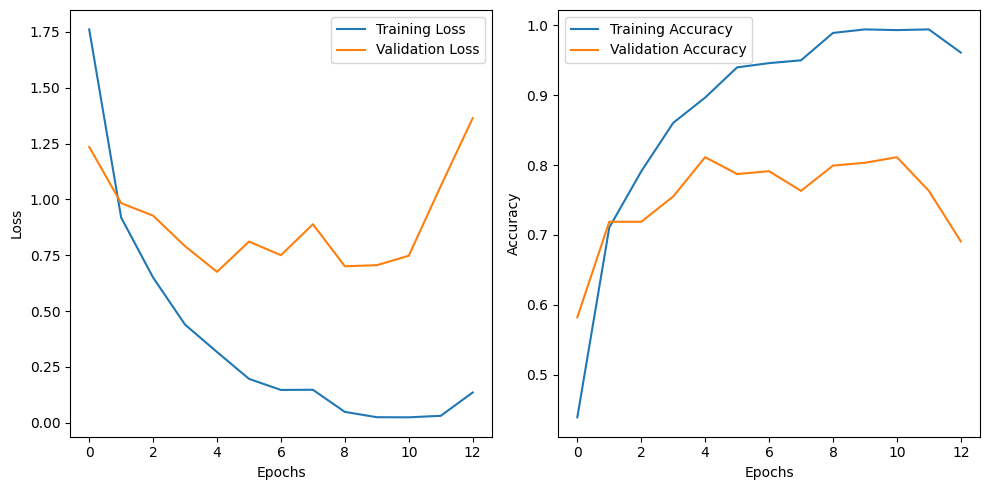

In [41]:
plot_history(CNN2D_Results)

In [42]:
show_evaluation_parameters(X_test_reshaped, y_test, CNN2D_Model, num_labels, encoder)

Accuracy score :  0.6907630522088354
Precision score:  0.7573310311658797
Recall score   :  0.6907630522088354
F1 Score       :  0.6775956025053111

--------------------------------------------

              precision    recall  f1-score   support

    barishal       0.45      0.95      0.61        19
      bogura       0.85      0.81      0.83        21
  chottogram       0.79      0.70      0.74        33
    kurigram       1.00      0.76      0.87        17
   madaripur       0.86      0.92      0.89        13
 maymenshing       0.93      0.81      0.87        16
    noakhali       0.68      0.76      0.72        34
       pabna       0.62      0.85      0.72        33
 puran dhaka       0.52      0.57      0.55        21
    rajshahi       1.00      0.17      0.29        18
   shatkhira       1.00      0.33      0.50         6
      sylhet       0.25      0.20      0.22         5
  thakurgaon       1.00      0.31      0.47        13

    accuracy                           0.69    

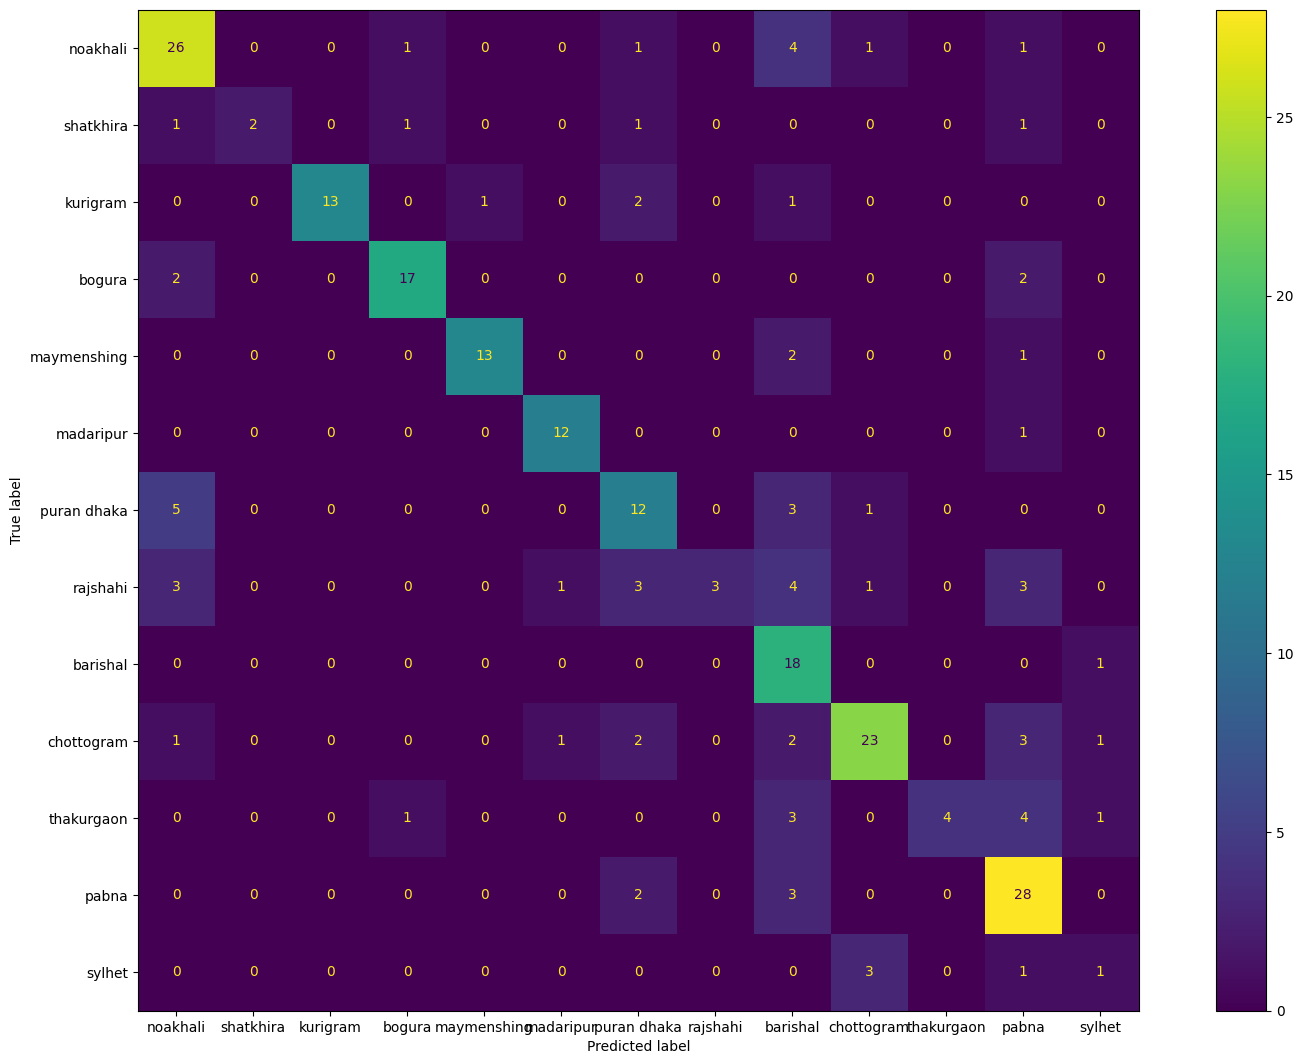

In [43]:
show_confusion_matrix(X_test_reshaped, y_test, CNN2D_Model, num_labels, encoder)